<a href="https://colab.research.google.com/github/manikBS/omscs-capstone/blob/master/yash_tft_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 2.4 MB/s eta 0:00:00-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 2.2 MB/s eta 0:00:00-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 2.2 MB/s eta 0:00:00a 0:00:01


In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=617be7646c06ad605e8a0aae71f4f6c0869d774f3599dc96cf5b5959400b5506
  Stored in directory: /Users/maniksomayaji/Library/Caches/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
# !pip install pytorch-forecasting --upgrade  # Ensure the latest version is installed

In [4]:
import os
import ta
import pandas as pd
import numpy as np

import torch
import pytorch_lightning as pl

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE


# TODO: Fill in the Google Drive path where you uploaded assignment1
# Example: If you create a Fall2023 folder and put all the files under A1 folder, then 'Fall2023/A1'
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'capstone_project'
user = 'ydosi3'
if user == 'ydosi3':
  GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive/Colab Notebooks', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
else:
  GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

import sys
sys.path.append(GOOGLE_DRIVE_PATH)

os.environ['GOOGLE_DRIVE_PATH'] = GOOGLE_DRIVE_PATH

os.environ['GOOGLE_DRIVE_PATH']

/opt/miniconda3/envs/cs7643-a3-nlp/lib/python3.11/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/capstone_project'

In [19]:
# Load and preprocess
data = pd.read_csv("/Users/maniksomayaji/Documents/omscs/capstone_project/data/NIFTY 50_minute_data.csv", parse_dates=['date'])
data1 = data[['open', 'high', 'low', 'close']].copy()

# Compute indicators
data1['RSI'] = ta.momentum.RSIIndicator(data1['close'], window=14).rsi()

macd = ta.trend.MACD(data1['close'], window_slow=26, window_fast=12, window_sign=9)
data1['MACD'] = macd.macd()
data1['MACD_signal'] = macd.macd_signal()
data1['MACD_diff'] = macd.macd_diff()

stoch = ta.momentum.StochasticOscillator(data1['high'], data1['low'], data1['close'], window=14)
data1['stoch'] = stoch.stoch()
data1['stoch_signal'] = stoch.stoch_signal()

# Add stock/group info
data1["stock"] = "NIFTY_IDX"

# Drop NaNs from indicators
data1.dropna(inplace=True)

# Create time_idx
data1["time_idx"] = data1.reset_index(drop=True).index

# Keep only up to 10,000 rows
df = data1[:10000].copy()
df.shape

In [24]:
from src.forecasting.GaussianTransformer import CustomTransformer
import torch.nn.functional as F

# ---------------------------
# 2. Setup forecasting parameters
# ---------------------------
max_encoder_length = 30   # lookback window (30 minutes)
max_prediction_length = 6 # forecast horizon (6 minutes)

training_cutoff = 9000

# ➤ Fix: filter out any group shorter than required
min_required = max_encoder_length + max_prediction_length

# In this case we have just one group, but safe to use for generalization
valid_groups = (
    df.groupby("stock")
    .filter(lambda x: len(x) >= min_required)
)

# ➤ Check for empty dataset after filtering
if valid_groups.empty:
    raise ValueError("No groups have enough data for the given encoder/prediction lengths.")


# ---------------------------
# 3. Create a TimeSeriesDataSet
# ---------------------------
# Here, we set the "target" as the 'close' price.
# "time_idx" is provided as a known variable, while the rest of the OHLC and indicator features are only used in history.
training_data = TimeSeriesDataSet(
    df[df.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="close",
    group_ids=["stock"],
    # Fixed history and forecast lengths:
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    # In our setting we assume that only the time index is known (you could add additional known features if available)
    time_varying_known_reals=["time_idx"],
    # Historical features (OHLC and the extra indicators) are unknown in the future and help inform past behavior
    time_varying_unknown_reals=["open", "high", "low", "close", "MACD", "MACD_signal", "MACD_diff", "stoch", "stoch_signal"],
    # Normalize the target by group. Softplus ensures non-negative predictions.
    target_normalizer=GroupNormalizer(groups=["stock"], transformation="softplus"),
)


In [29]:
# Create dataloaders for training and validation:
batch_size = 64
train_dataloader = training_data.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

# Build the validation dataset from the same dataset (ensuring consistent preprocessing)
validation_data = TimeSeriesDataSet.from_dataset(
    training_data, df[training_cutoff+1:], stop_randomization=True, predict=True, min_prediction_idx=training_cutoff+1
)

valid_dataloader = validation_data.to_dataloader(batch_size=batch_size, num_workers=0, train=False)

# Configure a PyTorch Lightning Trainer:
trainer = pl.Trainer(
    max_epochs=5,
    gradient_clip_val=0.1,
)

KeyboardInterrupt: 

In [ ]:
# Wrap the TFT model with the PyTorch Lightning module
class TFTLightningModule(pl.LightningModule):
    def __init__(self, tft):
        super().__init__()
        self.tft = tft
        self.train_losses_per_epoch = []
        self.validation_losses_per_epoch = []
        # self.save_hyperparameters(ignore=["model", "loss", "logging_metrics"])

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.tft(x)
        loss = F.mse_loss(y_hat["prediction"][:, :, 0], y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True,
                 batch_size=x['encoder_target'].shape[0])
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.tft(x)
        loss = F.mse_loss(y_hat["prediction"][:, :, 0], y)
        self.log("val_loss", loss, prog_bar=True, batch_size=x['encoder_target'].shape[0])
        return loss

    def test_step(self, batch, batch_idx):
        # Perform a single test step
        x, y = batch
        out = self.tft(x)
        y_pred = out[0]  # The model output is a tuple, 'y_pred' is the first element
        loss = F.mse_loss(y_pred, y)
        self.log("test_loss", loss, prog_bar=True, batch_size=x['encoder_target'].shape[0])
        return loss

    def on_train_epoch_end(self):
        self.train_losses_per_epoch.append(self.trainer.callback_metrics['train_loss'].item())
        self.validation_losses_per_epoch.append(self.trainer.callback_metrics['val_loss'].item())

model = CustomTransformer(d_model=9, nhead=3)
# Create an instance of the Lightning module, wrapping the TFT model
tft_lightning_module = TFTLightningModule(model)

# Train the model:
trainer.fit(
    tft_lightning_module,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

In [19]:
import matplotlib.pyplot as plt

# Access training and validation loss history
metrics = trainer.logged_metrics  # Get logged metrics


In [20]:
metrics

{'train_loss_step': tensor(0.0034),
 'val_loss': tensor(0.0059),
 'train_loss_epoch': tensor(0.0034)}

In [23]:
tft_lightning_module.train_losses_per_epoch

[0.006389246787875891,
 0.004342318512499332,
 0.004117479082196951,
 0.0036872646305710077,
 0.0034195990301668644]

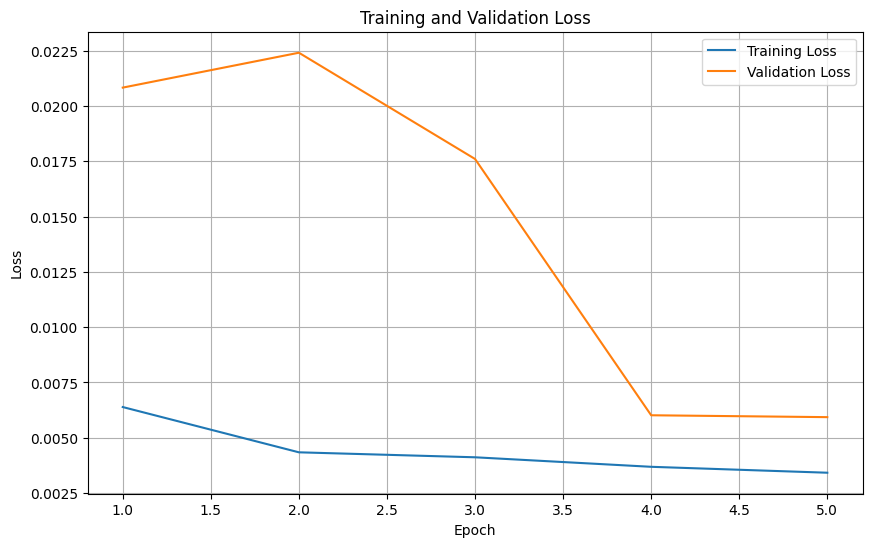

In [24]:
train_losses = tft_lightning_module.train_losses_per_epoch
val_losses = tft_lightning_module.validation_losses_per_epoch

# Create epoch array
epochs = range(1, len(train_losses) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
# Assuming you have 'data1' containing your entire dataset

# Select 30 minutes of data for testing
test_df = data1[10001:10031]  # Select data from index 10001 to 10030 (30 minutes)

# print(test_df.shape)
# Create test dataset and data loader
test_data = TimeSeriesDataSet.from_dataset(
    training_data,
    test_df,
    predict=False,
    stop_randomization=True,
    min_encoder_length=24,
    max_encoder_length=24,
    min_prediction_length=6,
    max_prediction_length=6
)

test_dataloader = test_data.to_dataloader(batch_size=1, num_workers=0, train=False)

# Get predictions
predictions = tft.predict(test_dataloader, mode="prediction")

# predictions will contain the 6-minute forecast for the 30-minute input data

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


(30, 12)


In [78]:
# TODO: Why do we need 36 mins instead of 30 mins? Or shorter encoder lenghts?
test_df = data1[10001:10031]
# create test dataset and data loader
test_data = TimeSeriesDataSet.from_dataset(
    training_data,
    test_df,
    predict=False,
    stop_randomization=True,
    min_encoder_length=24,
    max_encoder_length=24,
    min_prediction_length=6,
    max_prediction_length=6
)

test_dataloader = test_data.to_dataloader(batch_size=batch_size, num_workers=0, train=False)

In [79]:
num_batches = len(test_dataloader)
print(f"Number of batches in test_dataloader: {num_batches}")

# Estimate the total number of samples (may not be exact due to drop_last in DataLoader)
estimated_num_samples = num_batches * batch_size
print(f"Estimated number of samples in test_dataloader: {estimated_num_samples}")


Number of batches in test_dataloader: 1
Estimated number of samples in test_dataloader: 64


In [80]:
for batch_idx, batch in enumerate(test_dataloader):
    print(f"Batch {batch_idx + 1}:")

    # Accessing the data elements
    x, (y, _) = batch  # Unpack the batch into inputs (x) and targets (y)

    # Print the shapes and some sample data for each element
    print(f"  x (inputs): shape {x['encoder_target'].shape}, first 5 values: {x['encoder_target'][:5]}")
    # print(type(y))
    # print(len(y))
    # print(y[0])
    # print(y[1])
    print(f"  y (targets): shape {y.shape}, first 5 values: {y[:5]}")

    # Print any other relevant information from the batch, like other keys in 'x'
    # Example: print(f"  time_idx: {x['time_idx'][:5]}") if 'time_idx' in x else None

Batch 1:
  x (inputs): shape torch.Size([1, 24]), first 5 values: tensor([[8800.7002, 8802.9502, 8799.6504, 8800.0498, 8804.2998, 8807.4004,
         8804.1504, 8809.1504, 8805.2500, 8808.0000, 8808.4004, 8809.1504,
         8810.5498, 8815.5498, 8819.5996, 8816.5000, 8812.7998, 8819.3496,
         8820.0000, 8826.2500, 8828.4004, 8831.2002, 8833.4004, 8833.7998]])
  y (targets): shape torch.Size([1, 6]), first 5 values: tensor([[8832.4502, 8834.8496, 8834.5000, 8833.1504, 8831.0996, 8828.0498]])


In [81]:
r = tft.predict(test_dataloader, mode="raw", return_x=True)

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [82]:
r.output.prediction

tensor([[[8758.3154],
         [8754.6914],
         [8753.9590],
         [8753.8896],
         [8753.8955],
         [8753.9111]]])

In [68]:
r.x["encoder_target"]

tensor([[8800.7002, 8802.9502, 8799.6504, 8800.0498, 8804.2998, 8807.4004,
         8804.1504, 8809.1504, 8805.2500, 8808.0000, 8808.4004, 8809.1504,
         8810.5498, 8815.5498, 8819.5996, 8816.5000, 8812.7998, 8819.3496,
         8820.0000, 8826.2500, 8828.4004, 8831.2002, 8833.4004, 8833.7998,
         8832.4502, 8834.8496, 8834.5000, 8833.1504, 8831.0996, 8828.0498]])